## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [ ]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")



Les packages binaires t'el'echarg'es sont dans
	/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T//Rtmp7UmLdk/downloaded_packages


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
library(fastbmdR)
library(dplyr)
library(knitr)

In [7]:
## computing the BMD for the proteiomic data

#df <- read.csv("../00.exploratory_analysis/outputs/df_CC_Proba.csv", sep = ",")

df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]


models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df$Metadata_Compound)

feat_cols =colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table = list()

for (compound in unique_compounds) {
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- compound_data[, feat_cols]  
    compound_mat = t(compound_mat)  
    
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  

    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
 
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        

        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        

        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass



        res[[compound]] = fit_obj
        
        gene_table[[compound]] <- data.frame(
          gene_id = bmd_pass$gene.id,
          bmd_value = bmd_pass$bmd,
          bmd_l = bmd_pass$bmdl,
          bmd_u = bmd_pass$bmdu
        )
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- bmd_pass
          
        }
      }, error = function(e) {
        
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}



[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: Amperozide"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Lys05"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Imiquimod"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Cladribine"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Natamycin"
[1] "Processing compound: FCCP"
[1] "Processing compound: PEMIROLAST POTASSIUM"
[1] "Processing c

In [8]:
print(head(all_bmd_pass))

   gene.id mod.name          b           c            d         e  f
14  O75509     Exp3 -0.1143670          NA  3.379838530 0.1980932 NA
17  O95633     Hill 34.6716372 0.221668295  0.386127552 3.9496017 NA
23  P01033     Exp5  0.2407598 0.783097921 26.316819091 1.0087456 NA
26  P01137    Poly2  0.2283732 0.002553574 -0.001340157        NA NA
38  P02778    Poly2  0.2925605 0.024597761 -0.009279581        NA NA
54  P09237    Poly2  0.6551977 0.059432836 -0.021886616        NA NA
         SDres AIC.model     lof.p  ctrl.mod ctrl.mean adv.incr      bmd
14 0.008211004   -563.46 0.6519662 0.1980932 0.1982931    FALSE 4.222862
17 0.016819198   -442.04 0.4549779 0.3861276 0.3881075    FALSE 3.789597
23 0.024485361   -378.94 0.2610926 1.0087456 1.0095819    FALSE 3.939456
26 0.009087367   -546.42 0.1585079 0.2283732 0.2283012    FALSE 4.763624
38 0.039360910   -300.15 0.9953894 0.2925605 0.2931093    FALSE 4.516107
54 0.072715204   -197.04 0.9848081 0.6551977 0.6552882    FALSE 4.270484
      

In [9]:

## we can now create a table with the protein ids that has a response and their corresponding compound names

library(knitr)

gene_df <- do.call(rbind, lapply(names(gene_table), function(compound) {  
  gene_data <- gene_table[[compound]]  
  
  if (!is.null(gene_data) && nrow(gene_data) > 0) {  
    return(data.frame(
      gene_id = gene_data$gene_id,
      bmd = gene_data$bmd_value,
      bmd_l = gene_data$bmd_l,
      bmd_u = gene_data$bmd_u,
      compound_name = compound,
      stringsAsFactors = FALSE
    ))
  } else {  
    return(NULL)  
  }  
}))


print(gene_df)


     gene_id         bmd       bmd_l      bmd_u
1     O00175 4.345116044 4.243572592 4.43751050
2     O00220 3.756472035 3.639103351 3.86561025
3     O14625 4.597755438 4.557196405 4.63419588
4     O14672 4.700287605 4.653308392 4.74313383
5     O14836 4.136283551 4.063437418 4.20308504
6     O15467 4.093561793 4.063816240 4.12044322
7     O43508 4.733533321 4.522795344 4.93365398
8     O75144 4.464546827 4.398984517 4.52502817
9     O75509 1.179148060 0.999113133 1.39271826
10    O75888 3.669357892 3.574825613 3.75905477
11    O95760 4.581876158 4.498499552 4.65843622
12    P00533 3.688318236 3.526676614 3.83990418
13    P01031 4.440813946 4.388490154 4.48749366
14    P01137 2.011349473 1.631343357 2.42440601
15  P01137.1 4.580406926 4.462322655 4.69029013
16    P01138 4.390177909 4.343197019 4.43235838
17    P01374 4.768890040 4.735813244 4.79937339
18    P01579 4.086166060 3.946251521 4.21550394
19    P01583 3.708094091 3.578605721 3.82905473
20    P02775 3.597059718 3.233723037 3.9

In [10]:
## calculating the bmd values at real concentration

gene_df$Concentration <- NA
gene_df$Concentration_L <- NA
gene_df$Concentration_U <- NA

for (i in 1:nrow(gene_df)) {
  compound <- gene_df$compound_name[i]
  bmd <- gene_df$bmd[i]
  bmdl <- gene_df$bmd_l[i]
  bmdu <- gene_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  gene_df$Concentration[i] <- 10^(bmd - dose_shift)
  gene_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  gene_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}


In [11]:
kable(head(gene_df))




|gene_id |      bmd|    bmd_l|    bmd_u|compound_name | Concentration| Concentration_L| Concentration_U|
|:-------|--------:|--------:|--------:|:-------------|-------------:|---------------:|---------------:|
|O00175  | 4.345116| 4.243573| 4.437511|Actinomycin D |     110.68431|        87.60776|       136.92429|
|O00220  | 3.756472| 3.639103| 3.865610|Actinomycin D |      28.53922|        21.78078|        36.69275|
|O14625  | 4.597755| 4.557196| 4.634196|Actinomycin D |     198.02747|       180.37087|       215.36042|
|O14672  | 4.700288| 4.653308| 4.743134|Actinomycin D |     250.75962|       225.04968|       276.76032|
|O14836  | 4.136284| 4.063437| 4.203085|Actinomycin D |      68.43111|        57.86386|        79.80958|
|O15467  | 4.093562| 4.063816| 4.120443|Actinomycin D |      62.02001|        57.91436|        65.98014|

In [12]:
# Count the frequency of each protein

protein_freq <- table(gene_df$gene_id)

protein_freq_sorted <- sort(protein_freq, decreasing = TRUE)
head(protein_freq_sorted, 10)  # Top 10



Q14393 P09341 Q9H2A7 P0DJI8 Q12805 Q15113 Q16610 Q9BY76 P09237 P13500 
    16     14     14     13     13     13     13     13     12     12 

In [13]:
list_plot <- list()  

for (i in 1:nrow(gene_df)) {  
  tryCatch({
    gene_id <- gene_df$gene_id[i]
    compound <- gene_df$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$category <- df$Metadata_Categories[i]
    temp$bmd <- gene_df$bmd[i]
    temp$bmd_l <- gene_df$bmd_l[i]
    temp$bmd_u <- gene_df$bmd_u[i]
    temp$Concentration <- gene_df$Concentration[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

kable(head(final_df))



|  x| Observations|       f_x|protein |compound      |category         |      bmd|    bmd_l|   bmd_u| Concentration|
|--:|------------:|---------:|:-------|:-------------|:----------------|--------:|--------:|-------:|-------------:|
|  0|    0.1879041| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1960699| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.2082702| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1722449| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1719874| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1936951| 0.1882725|O00175  |Actinomycin D |Positive Control | 4.345116| 4.243573| 4.43751|      110.6843|

In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)


n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


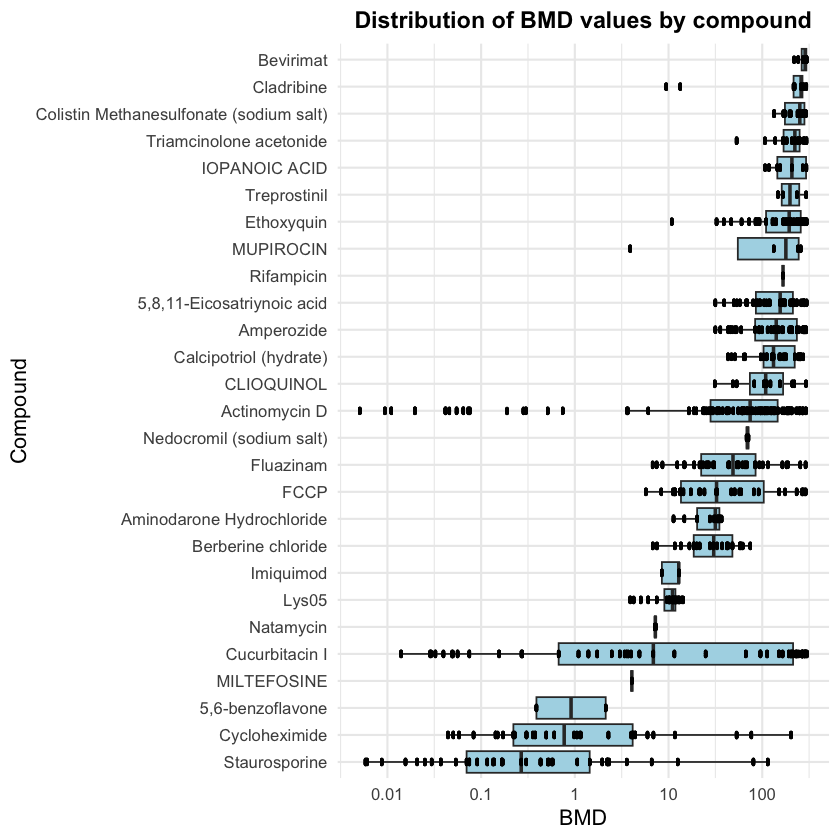

In [26]:
library(ggplot2)
library(dplyr)


df_bmd <- final_df[!is.na(final_df$Concentration), ]


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  arrange(median_bmd) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  labs(
    title = "Distribution of BMD values by compound",
    x = "BMD",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )




# A tibble: 27 x 5
   compound            mean_concentration min_concentration nb_proteins category
   <chr>                            <dbl>             <dbl>       <int> <chr>   
 1 5,6-benzoflavone                  1.26           0.389             2 Negativ~
 2 5,8,11-Eicosatriyn~             151.            31.6              33 Positiv~
 3 Actinomycin D                    96.8            0.00507         112 Positiv~
 4 Aminodarone Hydroc~              28.2           11.3              11 Negativ~
 5 Amperozide                      155.            31.6              46 Negativ~
 6 Berberine chloride               33.5            6.79             23 Negativ~
 7 Bevirimat                       274.           219.                8 Negativ~
 8 CLIOQUINOL                      128.            31.1              12 Negativ~
 9 Calcipotriol (hydr~             151.            43.2              25 Negativ~
10 Cladribine                      203.             9.44              9 Positiv~
# i 17 mo

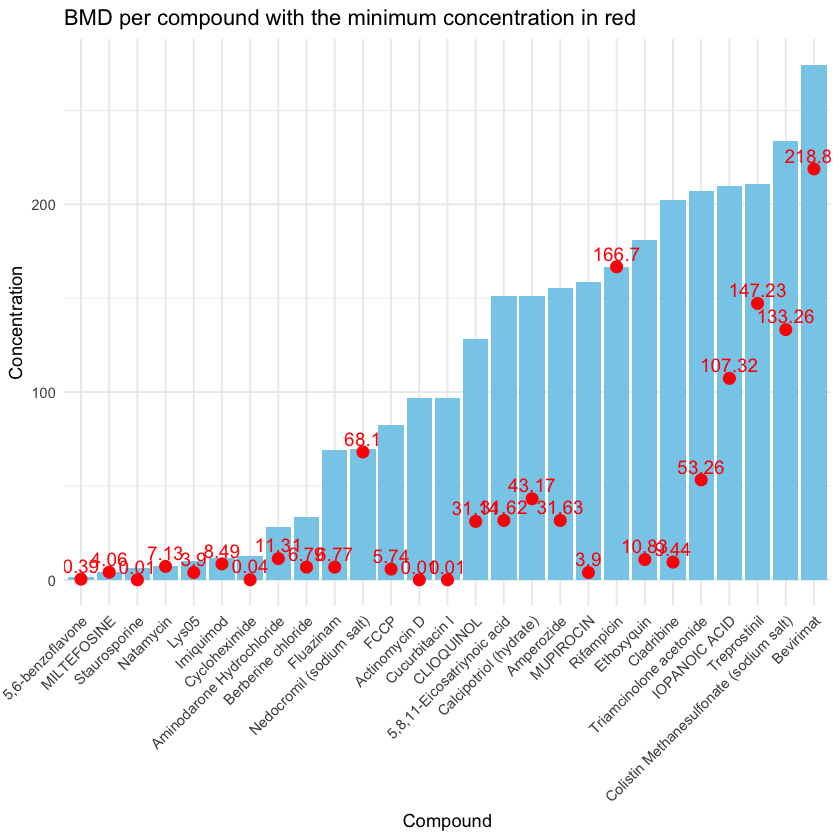

In [211]:
## Calculate the mean concentration for each compound


compound_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(protein ),
    category = first(category)              
  )


print(compound_summary)


p <- ggplot(compound_summary, aes(x = reorder(compound, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +  
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

print(p)

In [ ]:
#write.csv(compound_summary, "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/proteomic_bmd_dose_results.csv", row.names = FALSE)


In [105]:
print(compound_summary,  n = Inf)

# A tibble: 27 x 5
   compound            mean_concentration min_concentration nb_proteins category
   <chr>                            <dbl>             <dbl>       <int> <chr>   
 1 5,6-benzoflavone                  1.26           0.389             2 Negativ~
 2 5,8,11-Eicosatriyn~             151.            31.6              33 Positiv~
 3 Actinomycin D                    96.8            0.00507         112 Positiv~
 4 Aminodarone Hydroc~              28.2           11.3              11 Negativ~
 5 Amperozide                      155.            31.6              46 Negativ~
 6 Berberine chloride               33.5            6.79             23 Negativ~
 7 Bevirimat                       274.           219.                8 Negativ~
 8 CLIOQUINOL                      128.            31.1              12 Negativ~
 9 Calcipotriol (hydr~             151.            43.2              25 Negativ~
10 Cladribine                      203.             9.44              9 Positiv~
11 Colist

## Cell Count From CP data

In [1]:
getwd()

[1] "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response"

In [181]:
library(arrow)
library(dplyr)

raw_data <- read_parquet("../00.exploratory_analysis/CP_data/raw.parquet")

raw_data <- raw_data %>% 
  filter(Metadata_BROAD_ID != "EMPTY")


raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation)
  )

selected_data <- raw_data %>%
  select('Metadata_Well', 'Metadata_Count_Cells', 'Metadata_plate_map_name')


In [193]:
print(unique(raw_data$`Metadata_Compound Name`))

 [1] "AMG 900"                                
 [2] NA                                       
 [3] "Actinomycin D"                          
 [4] "Calcipotriol (hydrate)"                 
 [5] "NVS-PAK1-1"                             
 [6] "Treprostinil"                           
 [7] "Cladribine"                             
 [8] "Cucurbitacin I"                         
 [9] "FCCP"                                   
[10] "Dexamethasone (DHAP)"                   
[11] "CLIOQUINOL"                             
[12] "Bevirimat"                              
[13] "IOPANOIC ACID"                          
[14] "Staurosporine"                          
[15] "LY2109761"                              
[16] "Fluazinam"                              
[17] "MUPIROCIN"                              
[18] "Triamcinolone acetonide"                
[19] "Ethoxyquin"                             
[20] "FK-866"                                 
[21] "Cycloheximide"                          
[22] "5,6-ben

In [197]:
raw_data <- read_parquet("../00.exploratory_analysis/CP_data/raw.parquet")

raw_data <- raw_data %>% 
  filter(Metadata_BROAD_ID != "EMPTY")


raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation)
  )

subset_data <- raw_data[raw_data$`Metadata_Compound Name` == "Actinomycin D", ]

print(subset_data)

# A tibble: 20 x 5,589
   Metadata_plate_map_name Metadata_source_plate Metadata_source_well_position
   <chr>                   <chr>                 <chr>                        
 1 BR00145692              Plate1                B03                          
 2 BR00145692              Plate1                B04                          
 3 BR00145692              Plate1                B05                          
 4 BR00145692              Plate1                B06                          
 5 BR00145692              Plate1                B07                          
 6 BR00145692              Plate1                B08                          
 7 BR00145692              Plate1                B09                          
 8 BR00145692              Plate1                B10                          
 9 BR00145692              Plate1                B11                          
10 BR00145692              Plate1                B12                          
11 BR00145695              Pl

In [177]:
df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df_pred <- read.csv("./outputs/df_pred.csv", sep= ',')


We add the count cell columns from CP data to the proteomic data according to the plate number and compound well. 

In [178]:
library(dplyr)

df <- df %>%
  mutate(Metadata_plate_map_name = case_when(
    Metadata_Plate == "BR00145683" ~ "BR00145695",
    Metadata_Plate == "BR00145686" ~ "BR00145692",
    TRUE ~ Metadata_Plate 
  ))


In [179]:
df <- df %>%
  left_join(selected_data, 
            by = c("Metadata_Well" = "Metadata_Well", 
                   "Metadata_plate_map_name" = "Metadata_plate_map_name"))


df <- merge(df, df_pred[, c("Metadata_Well", "Metadata_plate_map_name", "Probability")], 
            by = c("Metadata_Well", "Metadata_plate_map_name"),
            all.x = TRUE)


In [ ]:
# I replace the missing values probability with 0 from Jump controls and DMSO

df$Probability[is.na(df$Probability)] <- 0

sum(is.na(df$Probability))


[1] 0

In [ ]:
#write.csv(df, file = "./outputs/df_CC_Proba.csv", row.names = FALSE)

#/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/outputs/bmd_curves.pdf

In [155]:
## 


#df <- read.csv("../00.exploratory_analysis/outputs/df_CC_Proba.csv")

df_cc <- df[, c("Metadata_Compound", 'Probability', "Metadata_Concentration", "Metadata_Count_Cells")]


print(head(df_cc))

df_cc <- df_cc[df_cc$Metadata_Compound != "UNTREATED", ]


df_cc <- df_cc %>%
  rename(
    CC0 = Metadata_Count_Cells,
    RF_prob= Probability
  )



  Metadata_Compound Probability Metadata_Concentration Metadata_Count_Cells
1         LY2109761        0.00                  5.100                 1570
2         UNTREATED        0.00                  0.000                   NA
3        Cladribine        0.50                  1.235                 3059
4     Actinomycin D        0.61                300.000                 1914
5      Treprostinil        0.55                  3.704                 3355
6         Bevirimat        0.61                  3.704                 4112


In [160]:
models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df_cc$Metadata_Compound)

feat_cols = colnames(df_cc)[!grepl("Metadata", colnames(df_cc))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()  # Initialisation vide pour accumuler les résultats

for (compound in unique_compounds) {
  
  compound_data <- df_cc[df_cc$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass)  # Ajout des résultats
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}


[1] "Processing compound: Cladribine"
[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Aminodarone Hydrochloride"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Amperozide"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Lys05"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Colistin Methanesulfonate (sodium salt)"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Imiquimod"
[1] "Error wit

In [199]:
print(all_bmd_pass)

   gene.id mod.name             b          c           d        e  f
2  RF_prob    Poly2  7.906616e-02  0.3680495 -0.05031399       NA NA
21 RF_prob    Poly2  7.597098e-02  0.3387782 -0.05247251       NA NA
1      CC0     Exp3 -2.057070e-01         NA 31.23287292 4372.780 NA
22 RF_prob    Poly2  7.962573e-02  0.3586920 -0.04988601       NA NA
23 RF_prob    Poly2  8.044503e-02  0.3095797 -0.04730009       NA NA
11     CC0    Power -1.110953e-09 18.0000000          NA 4373.652 NA
24 RF_prob    Poly2  7.824405e-02  0.4673036 -0.08536771       NA NA
25 RF_prob    Poly2  7.910000e-02  0.3979536 -0.05642828       NA NA
26 RF_prob    Poly2  7.771798e-02  0.3741742 -0.06536383       NA NA
27 RF_prob    Poly2  7.811266e-02  0.3968893 -0.06506998       NA NA
12     CC0     Exp3 -2.086853e-01         NA 41.40652248 4440.298 NA
28 RF_prob    Poly2  9.199010e-02  0.3965775 -0.07016997       NA NA
         SDres AIC.model     lof.p     ctrl.mod    ctrl.mean adv.incr       bmd
2    0.1771449    -47.4

In [200]:
print(head(all_bmd_pass))

   gene.id mod.name             b          c           d        e  f
2  RF_prob    Poly2  7.906616e-02  0.3680495 -0.05031399       NA NA
21 RF_prob    Poly2  7.597098e-02  0.3387782 -0.05247251       NA NA
1      CC0     Exp3 -2.057070e-01         NA 31.23287292 4372.780 NA
22 RF_prob    Poly2  7.962573e-02  0.3586920 -0.04988601       NA NA
23 RF_prob    Poly2  8.044503e-02  0.3095797 -0.04730009       NA NA
11     CC0    Power -1.110953e-09 18.0000000          NA 4373.652 NA
         SDres AIC.model     lof.p     ctrl.mod    ctrl.mean adv.incr      bmd
2    0.1771449    -47.45 0.2030283    0.6716496 6.953125e-02     TRUE 1.103034
21   0.1685616    -55.79 0.3750060    0.4967188 6.953125e-02     TRUE 1.198638
1  700.4499679   1344.02 0.8385135 4372.7801140 4.394312e+03    FALSE 4.712587
22   0.1768159    -47.76 0.1046765    0.6995365 6.953125e-02     TRUE 1.137798
23   0.1733262    -51.11 0.1071846    0.2173845 6.953125e-02     TRUE 1.372180
11 727.7219581   1350.43 0.1607321 4373.651

In [201]:

list_plot <- list()

for (i in 1:nrow(all_bmd_pass)) {
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]

    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")

    temp$protein   <- gene_id
    temp$compound  <- compound
    #temp$category  <-
    temp$bmd       <- all_bmd_pass$bmd[i]
    temp$bmd_l     <- all_bmd_pass$bmdl[i]
    temp$bmd_u     <- all_bmd_pass$bmdu[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Erreur pour gene_id %s et compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)
kable(final_df)

Erreur pour gene_id CC0 et compound 5,8,11-Eicosatriynoic acid : les arguments impliquent des nombres de lignes diff'erents : 100, 0





|         x| Observations|          f_x|protein |compound                                |       bmd|     bmd_l|     bmd_u|
|---------:|------------:|------------:|:-------|:---------------------------------------|---------:|---------:|---------:|
| 0.0000000|         0.57|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.84|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.27|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.39|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.00

In [166]:
## calculating the bmd values at real concentration

final_df$Concentration <- NA
final_df$Concentration_L <- NA
final_df$Concentration_U <- NA

for (i in 1:nrow(final_df)) {
  compound <- final_df$compound[i]
  bmd <- final_df$bmd[i]
  bmdl <- final_df$bmd_l[i]
  bmdu <- final_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  final_df$Concentration[i] <- 10^(bmd - dose_shift)
  final_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  final_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}

In [173]:
kable(final_df)



|         x| Observations|          f_x|protein |compound                                |       bmd|     bmd_l|     bmd_u| Concentration| Concentration_L| Concentration_U|
|---------:|------------:|------------:|:-------|:---------------------------------------|---------:|---------:|---------:|-------------:|---------------:|---------------:|
| 0.0000000|         0.57|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|     0.0633876|       0.0455317|       0.0900087|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|     0.0633876|       0.0455317|       0.0900087|
| 0.0000000|         0.84|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|     0.0633876|       0.0455317|       0.0900087|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|     0.063

In [168]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file


library(ggplot2)
library(ggforce)

# Filtrer les données pour le type de protéine "CC0"
final_df_CC0 <- final_df[final_df$protein == "CC0", ]

n_per_page <- 9  

final_df_CC0$compound_protein <- paste(final_df_CC0$compound, final_df_CC0$protein, sep = " - ")

plot_groups_CC0 <- unique(final_df_CC0$compound_protein)
n_pages_CC0 <- ceiling(length(plot_groups_CC0) / n_per_page)

pdf_file_CC0 <- "./outputs/cc0_bmd_curves.pdf"
pdf(pdf_file_CC0, width = 15, height = 10)

for (i in 1:n_pages_CC0) {
  tryCatch({
    p <- ggplot(final_df_CC0, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - CC0 - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 196 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [174]:

final_df_RF_prob <- final_df[final_df$protein == "RF_prob", ]

n_per_page <- 9  

final_df_RF_prob$compound_protein <- paste(final_df_RF_prob$compound, final_df_RF_prob$protein, sep = " - ")

plot_groups_RF_prob <- unique(final_df_RF_prob$compound_protein)
n_pages_RF_prob <- ceiling(length(plot_groups_RF_prob) / n_per_page)

pdf_file_RF_prob <- "./outputs/RFprob_bmd_curves.pdf"
pdf(pdf_file_RF_prob, width = 15, height = 10)

for (i in 1:n_pages_RF_prob) {
  tryCatch({
    p <- ggplot(final_df_RF_prob, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - RF_prob - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 882 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [49]:
## Calculate the mean concentration for each compound


compound_summary <- final_df %>%
  group_by(compound, protein) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    .groups = "drop"
  )

print(compound_summary)


# A tibble: 11 x 3
   compound                                protein mean_concentration
   <chr>                                   <chr>                <dbl>
 1 Actinomycin D                           CC0              127.     
 2 Actinomycin D                           RF0                0.0739 
 3 Berberine chloride                      RF0                0.00991
 4 Cladribine                              RF0                0.0634 
 5 Colistin Methanesulfonate (sodium salt) CC0              293.     
 6 Colistin Methanesulfonate (sodium salt) RF0                0.0440 
 7 Cucurbitacin I                          RF0                0.0613 
 8 Ethoxyquin                              CC0              272.     
 9 MUPIROCIN                               RF0                0.0687 
10 Natamycin                               RF0                0.00583
11 Staurosporine                           RF0                0.118  
